In [1]:
#import important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
#set width of column
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 999
#suppress warning
import warnings
warnings.filterwarnings("ignore")
#translation api
from googletrans import Translator
import math

In [113]:
#Read CSV
#test using 20_24
file = '2017_12_13_00_09.csv'
fake= pd.read_csv(file)
fake=fake.drop(['device_type','product_name','event_id','device_id','device_hw_form'],axis=1)
## drop row whose info is almost lost
fake=fake[fake['device_hw_ram'].notnull()]
fake.head()

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version
0,Intel64 Family 6 Model 78 Stepping 3 Intel(R) Core(TM) i7-6600U CPU @ 2.60GHz,8GB 1073741824,"1920x1080 120,120 32, 1920x1080 120,120 32","Intel(R) HD Graphics 520, PCI\VEN_8086&DEV_1916&SUBSYS_8079103C&REV_07\3&11583659&0&10, \\.\DISPLAY1",Microsoft Windows 7 Enterprise,6.1.7601 Service Pack 1 Build 7601
1,Intel64 Family 6 Model 79 Stepping 1 Intel(R) Core(TM) i7-6950X CPU @ 3.00GHz,128GB 4293918720,"1600x1200 144,144 32, 1800x2400 144,144 32","NVIDIA GeForce GTX 1080, PCI\VEN_10DE&DEV_1B80&SUBSYS_33661462&REV_A1\4&16DD647B&0&001A, \\.\DISPLAY1",Microsoft Windows 10 Pro,10.0.15063 Build 15063
2,Intel64 Family 6 Model 69 Stepping 1 Intel(R) Core(TM) i5-4210U CPU @ 1.70GHz,8GB 2181038080,"1366x768 Touch 96,96 32","Intel(R) HD Graphics Family, PCI\VEN_8086&DEV_0A16&SUBSYS_2212103C&REV_0B\3&11583659&1&10",Microsoft Windows 8.1,6.3.9600 Build 9600
3,Intel(R) Core(TM) i5-4210U CPU @ 1.70GHz,4GB,1366x768,Intel(R) HD Graphics Family,Microsoft Windows 7 Professional,6.1.7601 Service Pack 1 Build 7601
4,Intel64 Family 6 Model 78 Stepping 3 Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz,4GB 1073741824,"2880x1920 Touch 192,192 32","Intel(R) HD Graphics 520, PCI\VEN_8086&DEV_1916&SUBSYS_13C01043&REV_07\3&11583659&1&10",Microsoft Windows 10 Home Single Language,10.0.14393 Build 14393


In [89]:
fake[(fake.device_hw_display.str.contains('Touch'))&(fake.device_hw_display.str.contains('Retina'))]

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version


In [114]:
def deleteStepping(s,brand,stepping):
    length=len(stepping)-1
    
    start = s[s.find(brand)+length:].find(brand)+length
    
    return s[start:]

def splitC(s):
    ##make data consistent#
    s=" ".join(s.split())
    
    if 'Pentium(R)' in s and 'Intel(R) Pentium(R)' not in s:
        s= s.replace('Pentium(R)','Intel(R) Pentium(R)')
    elif 'Celeron(R)' in s and 'Intel(R) Celeron(R)' not in s:
        s= s.replace('Celeron(R)','Intel(R) Celeron(R)')
    elif 'Intel(R)' in s and 'Core(TM)' not in s and 'Core' in s and '-Core' not in s:
        s= s.replace('Core','Core(TM)')
    elif 'AMD64' in s and 'Quad-Core' in s:
        s=s.replace('Quad-Core','AMD Quad-Core')
    elif 'Quad-Core' in s and 'Processor' in s:
        s=s.replace('Quad-Core','AMD Quad-Core')
    else:
        s=s

        
    if 'AMD' in s and 'RADEON' in s:
        s= s.replace('RADEON','Radeon') 
    if 'AMD' in s and " APU with AMD " in s:
        s=s.replace(" with AMD "," ")
    if 'AMD' in s and " APU " in s:
        s=s.replace(" APU "," ")
    if 'AMD' in s and " with " in s:
        s=s.replace(" with "," ")
    if 'AMD' in s and " Graphics" in s:
        s=s.replace("Graphics","")
    if 'AMD' in s and "Radeon(TM)" in s:
        s=s.replace("Radeon(TM)","Radeon")
    if "Radeon(tm)" in s:
        s=s.replace("Radeon(tm)","Radeon")
    
    if 'i3 ' in s and 'i3-' not in s:
        s=s.replace('i3 ','i3-')
    elif 'i5 ' in s and 'i5-' not in s:
        s=s.replace('i5 ','i5-')
    elif 'i7 ' in s and 'i7-' not in s:
        s=s.replace('i7 ','i7-')
    else:
        s=s
        
    ###extract with comma
    if ',' in s:
        first=s.split(',')[0]
        second=s.split(',')[1].lstrip()
        if 'Intel64' in first and 'Intel64' in second:
            firstN = deleteStepping(first,'Intel','Intel64')
            secondN=deleteStepping(second,'Intel','Intel64')
            return (firstN,secondN)      
        elif 'Intel' in first and 'Intel' in second:
            start1 = first.find('Intel')
            start2 = second.find('Intel')
            return (first[start1:],second[start2:])
        elif 'AMD' in first  and ('CORES' in second.upper() or '+' in second):
            if 'AMD64' in first:
                return deleteStepping(first,'AMD','AMD64')
            else:
                start = first.find('AMD')
                s= first[start:]
                return s
        elif 'AMD64' in first and 'AMD64' in second:
            firstN = deleteStepping(first,'AMD','AMD64')
            secondN = deleteStepping(second,'AMD','AMD64')
            return (firstN,secondN)
        elif 'AMD' in second and 'AMD' in first:
            start1 = first.find('AMD')
            start2 = second.find('AMD')
            return (first[start1:],second[start2:])
        elif 'AMD' not in s and 'Intel' not in s:
            return 'Unusual'
        else:
            return 'Unusual'
    else:
        if 'Intel' in s and 'Intel64' in s:
            start = s[s.find('Intel64')+6:].find('Intel')+6
        elif 'Intel' in s and 'Genuine' in s:
            start = s.find('Genuine')
        elif 'Intel' in s:
            start = s.find('Intel')       
                    
        elif 'AMD64' in s:
            if 'AMD ' in s:
                start =s[s.find('AMD64')+4:].find('AMD')+4
            else:
                start=s.find('AMD64')
        elif ('x64' in s  or 'x86' in s) and 'AMD' in s:
            start =s.find('AMD')
        else:
            start=0
            
    s=" ".join(s.split())
       
    return s[start:]

def splitB(s):
    if len(s)!=2:
        if 'Intel' in s:
            if 'CPU' in s:
                s=s.replace('CPU',' ')
            if '@' in s:
                end = s.find('@')
            elif '-' in s:
                end = s.find('-')+5
            else:
                end=len(s)+1

            if 'Genuine' in s:
                start = s.find('Genuine')
            elif 'Intel(R)' in s:
                start = s.find('Intel(R)')+8
            else:
                start=0
            sn=s[start:end]
        else:
            sn=s
    else:
        return s
    
    ##correct Core(TM)2 E series
    if 'Core(TM)2' in s and 'Core(TM)2 Duo' not in s and 'Quad' not in s:
        sn=sn.replace('Core(TM)2','Core(TM)2 Duo')
    elif 'Core(TM) Duo' in s and 'Core(TM)2 Duo' not in s:
        sn=sn.replace('Core(TM) Duo','Core(TM)2 Duo')
    else:
        sn=sn
    sn=" ".join(sn.split()) 
    ###correct E series
    series = [' 4300',' 4400',' 6300',' 6320',' 6400',' 6420',' 6600',' 6700']


    if 'Core(TM)2 Duo'in sn:
        for sery in series:
            if 'Core(TM)2 Duo'+sery in sn:
                sn=sn.replace(sery,' E'+sery.lstrip())
                break
    return sn    

def getC(df,threshold):
    df=(100*df.brand.value_counts()/len(df.brand)).sort_values()
    listR=df[df.cumsum()>threshold].index
    return listR

###filter the RAM you want. Otherwise, it will be treated as "Rare". Criteria is the cumulative proportion.
def filterC(s,listC):
    if s in listC:
        return s
    else:
        return 'Rare'
    

def consis(s):
    if 'Intel' in s and 'Intel(R)' not in s:
        s=s.replace('Intel','Intel(R)')
    if 'Intel(R)' in s and 'Intel(R) -' in s:
        s=s.replace('Intel(R) -','Intel(R)')
    if 'Intel(R)' in s and 'Family ' in s:
        s=s.replace('Family ','Family')
    if 'Intel' in s and '(PE) ' in s:
        s=s.replace('(PE) ','')
    if 'Intel' in s and '(PE64) ' in s:
        s=s.replace('(PE64) ','')
    
    if 'Radeon(TM)' in s:
        s=s.replace('Radeon(TM)','Radeon')
    if 'Radeon (TM)' in s:
        s=s.replace('Radeon (TM)','Radeon')
    if 'RADEON' in s:
        s=s.replace('RADEON','Radeon')
    if 'Radeon.' in s:
        s=s.replace('Radeon.','Radeon')
    if 'RadeonT' in s:
        s=s.replace('RadeonT','Radeon')
    
    if 'Radeon' in s and 'AMD' not in s and 'ATI' not in s:
        s=s.replace('Radeon','AMD(ATI) Radeon')
    if 'ASUS' in s and 'Radeon' in s:
        s=s.replace('ASUS','')
    if 'Intel' in s and 'Iris' in s and 'Iris(TM)' not in s:
        s=s.replace('Iris','Iris(TM)')
    if 'Intel' in s and 'Iris(R)' in s:
        s=s.replce('Iris(R)','Iris(TM)')
    if 'ATI' in s and 'AMD' not in s:
        s=s.replace('ATI','AMD(ATI)')
    if 'AMD' in s and 'ATI' not in s:
        s=s.replace('AMD','AMD(ATI)')
    
    # delete redundant info
    if 'AMD' in s or 'Intel(R)' in s or 'NVIDIA' in s:
        if '(Microsoft Corporation - WDDM 1.0)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.0)','')
        elif '(Microsoft Corporation - WDDM 1.1)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.1)','') 
        elif '(Microsoft Corporation - WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation - WDDM 1.2)','')
        elif '(Microsoft Corporation — WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation — WDDM 1.2)','')
        elif '(Microsoft Corporation — WDDM 1.2)' in s:
            s=s.replace('(Microsoft Corporation — WDDM 1.2)','')
        elif '(Microsoft Corporation - WDDM v1.1)' in s:
            s=s.replace(' (Microsoft Corporation - WDDM v1.1)','')
        elif '(Microsoft Corporation WDDM 1.1)' in s:
            s=s.replace('(Microsoft Corporation WDDM 1.1)','')
        elif '(Microsoft Corporation - WDDM v1.20)' in s:
            s=s.replace('(Microsoft Corporation - WDDM v1.20)','')
        elif '(Microsoft Corporation - WDDM v1.2)' in s:
            s=s.replace('(Microsoft Corporation - WDDM v1.2)','')
        elif '(Engineering Sample - WDDM v1.1)' in s:
            s=s.replace('(Engineering Sample - WDDM v1.1)','')
        elif '(Microsoft Corporation - WDDM)' in s:
            s=s.replace('(Microsoft Corporation - WDDM)','')
        elif '(Microsoft Corporation- WDDM v1.20)' in s:
            s=s.replace('(Microsoft Corporation- WDDM v1.20)','')
        elif '(Bootcamp XG edition by bootcampdrivers.com)' in s:
            s=s.replace('(Bootcamp XG edition by bootcampdrivers.com)','')
        elif '(Engineering Sample - WDDM v1.20)' in s:
            s=s.replace('(Engineering Sample - WDDM v1.20)','')
        else:
            s=s
    # Clean ASUS
    if 'ASUS' in s:
        if 'EAH' in s:
            s=s.replace('ASUS ','AMD(ATI) Radeon ').replace('EAH', 'HD ').replace(' Series','') 
        elif 'HD' in s:
            s=s.replace('ASUS ','AMD(ATI) Radeon ').replace('HD','HD ').replace(' Series','')
        elif 'R5' in s or 'R7' in s or 'R9' in s:
            s=s.replace('ASUS','AMD(ATI) Radeon ').replace(' Series','')
        else:
            s='UNKNOWN'
        s=" ".join(s.split())
    
    if 'AMD' in s and (' Series' in s or ' Graphics' in s or ' series' in s or ' graphics' in s or ' Graphic' in s):
        s=s.replace(' Series','')
        s=s.replace(' series','')
        s=s.replace(' Graphics','')
        s=s.replace(' graphics','')
        s=s.replace(' Graphic','')

        
    s=" ".join(s.split())
    return s                                                

        

def cleanGC(s):
    if isinstance(s, float)==True:
        return s
    
    s=consis(s)
    
    if ',' in s:
        names = s.split(',')
        new = []
        for name in names:
            if '\\' not in name and 'PCI' not in name and 'ROOT' not in name and '%' not in name:
                new.append(name)
        s= ",".join(new)
    elif s[0]=='@' or s[0]=='\\' or s.startswith('PCI'):
        s='UNKNOWN'
        
    
    if ';' in s:
        names = s.split(';')
        new = []
        for name in names:
            if '%' not in name and '@' not in name:
                new.append(name)
        s=";".join(new)
    if s=='' or s[0]=='@' or s[0]=='%':
        return 'UNKNOWN'
    return s

def lzytrans(s):
    if isinstance(s, float)==True:
        return s  
    if ('Microsoft' in s or 'Майкрософт' in s) and ('Adaptador' in s or '适配器' in s or 'видеоадаптер' in s or '기본 디스플레이 어댑터' in s or 'Vídeo Básico' in s or 
                               'Görüntü Bağdaştırıcısı' in s or '基本顯示卡' in s or 'vidéo' in s or 'ディスプレイ アダプター' in s or 
                              'Základní grafický adaptér' in s or 'Placa Gráfica Básica da' in s or 'Microsoftin perusnäyttösovitin' in s or
                            'Microsoft Basic-skærmkort' in s or 'Βασικός προσαρμογέας οθόνης Microsoft' in s or 'Базовый видеоадаптер' in s or
          'videokártya' in s or '기본 디스플레이 드라이버' in s or 'Podstawowa karta graficzna' in s or 'Scheda video' in s):
        s= 'Microsoft Basic Display Adapter'
    elif 'Hyper-V' in s or 'Video för Hyper-V från Microsoft' in s:
        s= 'Microsoft Hyper-V-Video'
    elif 'VGA' in s and 'VMware' not in s and 'Wifi' not in s:
        s='Standard VGA Graphics Adapter'
    elif 'Семейство наборов микросхем Intel(R) G33/G31 Express' in s or 'Intel(R) G33/G31 Express Yonga Kümesi Ailesi' in s\
          or 'Familia Intel(R) G33/G31 Express Chipset' in s:
        s='Intel(R) G33/G31 Express Chipset Family'
    elif 'Набор микросхем Intel(R) G41 Express' in s or 'Intel(R) Express Chipset G41' in s:
        s='Intel(R) G41 Express Chipset'
    elif 'Mikroukład Intel(R) Q45/Q43 Express Chipset' in s or 'Набор микросхем Intel(R) Q45/Q43 Express' in s\
          or 'Intel(R) Express Chipset Q45/Q43' in s:
        s='Intel(R) Q45/Q43 Express Chipset'
    elif 'Семейство наборов микросхем Mobile Intel(R) 45 Express' in s or 'Mobile Intel(R) 45 Express lapkakészletcsalád' in s\
          or 'Familia Mobile Intel(R) 45 Express Chipset' in s:
        s='Mobile Intel(R) 45 Express Chipset Family'

    elif 'Familia Intel(R) 82945G Express Chipset' in s:
        s='Intel(R) 82945G Express Chipset Family'
    elif 'Familia Mobile Intel(R) 965 Express Chipset' in s:
        s='Mobile Intel(R) 965 Express Chipset Family '
    elif 'Intel(R) - famiglia Express Chipset Q965/Q963' in s:
        s='Intel(R) Q965/Q963 Express Chipset'
    elif 'Familia' in s:
        s=s.replace('Familia','')+' Family'
    else:
        s=s
    
    """"
    # takes long time to run
    if isEnglish(s)==False:
        translator = Translator()
        t=translator.translate(s).text.title()
        s=t
    """
    if 'корпорация Майкрософт' in s:
        s=s.replace('корпорация Майкрософт','Microsoft Corporation')
    return s

def solveVM(s):
    if isinstance(s, float)==True:
        return s
    elif 'VGA' in s.upper():
        if 'VMware' in s:
            return 'VMware SVGA 3D'
        elif 'Standard' in s or 'Scheda' in s or 'Standardowa' in s or 'standard' in s:
            return 'Standard VGA Graphics Adapter'
        elif 'Wifi' in s:
            return 'Wireless'
        else:
            return s
    elif 'Microsoft' in s and ('Basic' in s or 'Base' in s):
        return 'Microsoft Basic Display Adapter'
    elif 'Microsoft' in s and 'Hyper' in s:
        return 'Microsoft Hyper-V Video'
    elif 'Intel' in s and 'Intel(R)' not in s:
        s=s.replace('Intel','Intel(R)')
        if 'Iris' in s and 'Iris(TM)' not in s:
            s=s.replace('Iris','Iris(TM)')
        elif 'Iris(R)' in s:
            s=s.replce('Iris(R)','Iris(TM)')
        if s.startswith('The'):
            s= s.replace('The','')
        return s
    elif 'Mirage' in s or 'Mirror' in s or 'BB Capture Driver' in s:
        return 'Mirror'
    elif 'Remote' in s or 'RC' in s:
        return 'Remote'
    elif 'DisplayLink USB' in s or 'Projector' in s:
        return 'Wireless'
    elif 'Parallels Display' in s or 'hook driver' in s or 'Citrix Display' in s or 'ShoreTel Desktop' in s\
          or 'VirtualBox Graphics' in s or 'Fujitsu Live Help graphics driver' in s or \
          'Freedom Scientific Accessibility' in s or 'ASPEED Graphics Family' in s:
        return 'Remote'
    else:
        s=s
    s=" ".join(s.split())
    return s

##### clean the duplicate GPU info
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def mergeGPU(row):
    s=row['GC']
    
    if isinstance(s, float)==True:
        return s
    
    if ',' in s and row['CPU#']==1:
        if s.count('Intel(R)')>=2:
            start=find_nth(s,'Intel',2)
            s=s[:start]
        elif s.count('NVIDIA')>=2:
            start=find_nth(s,'NVIDIA',2)
            s=s[:start]
        elif s.count('AMD')>=2:
            start=find_nth(s,'AMD',2)
            s=s[:start]
        else:
            return 'Duplicate GPU'
    elif ',' in s and row['CPU#']==2:
        return '2 GPUs'
    else:
        s=s
    s=" ".join(s.split())
    return s

def loadGC(s):
    #consistent and clean
    s=cleanGC(s)
    s=lzytrans(s)
    s=solveVM(s)
    return s

def typeGPU(s):
    if isinstance(s, float)==True:
        return 'UNKNOWN'
    
    if 'Intel' in s:
        return 'Intel'
    elif 'AMD' in s:
        return 'AMD'
    elif 'NVIDIA' in s:
        return 'NVIDIA'
    elif 'Microsoft Basic Display' in s:
        return s
    elif 'Microsoft Hyper-V Video' in s:
        return s
    elif 'Mirror' in s:
        return 'Mirror'
    elif 'Remote' in s:
        return 'Remote'
    elif 'VMware' in s:
        return s
    elif 'UNKNOWN' in s:
        return s
    elif 'Wireless' in s:
        return s
    elif 'Matrox' in s:
        return 'Matrox'
    elif 'Standard VGA' in s:
        return 'Standard VGA Graphics Adapter'
    elif 'Windows Live Display Driver' in s:
        return s
    else:
        return 'Others'

def splitR(s):
    if s =='UNKNOWN':
        return np.nan
    elif 'GB' in s:
        return s[:s.find('GB')]
    else:
        return 'Others'
    
def getL(df,threshold):
    df=(100*df.RAM.value_counts().sort_index()/len(df.RAM)).sort_values()
    listR=df[df.cumsum()>threshold].index
    return listR

###filter the RAM you want. Otherwise, it will be treated as "Rare". Criteria is the cumulative proportion.
def filterR(s,listR):
    if s in listR:
        return s
    else:
        return 'Rare'
    

def findOS(s):

    if 'WINDOWS' in s.upper() or 'enterprise' in s or 'Microsoft' in s or 'Майкрософт' in s:
        
        x='Windows'
    
        if 'pro' in s.lower() or 'professional' in s.lower() or '专业' in s or '專業' in s or 'Профессиональная' in s or 'Altum' in s:
            return x+' Pro'
        elif 'Home' in s or '家庭' in s or '家用' in s or 'Famille' in s or 'Домашняя' in s or 'Familiale' in s:
            return x+' Home'
        elif '企业' in s or 'entreprise' in s.lower() or '企業' in s or 'Корпоративная' in s or 'enterprise' in s.lower():
            return x+' Entreprise'
        elif 'education' in s.lower() or '教育' in s or 'Éducation' in s: 
            return x+' Education'
        elif '旗舰' in s or 'ultimate' in s.lower() or 'Максимальная' in s or '旗艦' in s or 'Intégrale' in s:
            return x+' Ultimate'
        elif 'CRUX' in s:
            return x+' Crux'
        elif 'Windows Server 2012 R2' in s:
            return x+' Server 2012 R2'
        elif 'Windows Server 2016 ' in s:
            return x+' Server 2016'
        elif 'Windows Server 2012' in s and 'R2' not in s:
            return x+' Server 2012'
        elif 'Windows Server 2008 R2' in s:
            return x+' Server 2008 R2'
        elif 'Starter' in s or 'Начальная' in s or '简易' in s:
            return x+' Starter'
        elif 'Embedded' in s:
            return 'NA'
        elif 'Luxury' in s:
            return x+' Luxury'
        elif ' MultiPoint Server 2012' in s:
            return x+' MultiPoint Server 2012'
        else:
            return x+' Standard'  # without knowledge of which edition
    elif 'MAC' in s.upper() or 'Yosemite' in s or 'EI Capitan' in s:
        return 'Mac'
    elif 'UNKNOWN' in s:
        return 'UNKNOWN'
    else:
        return 'Others'

def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start


def splitone(s):
    if 'Retina' in s:
        return s[:s.find('Retina')+6]
    elif 'Touch' in s:
        return s[:s.find('Touch')+5]
    else:
        return s.split()[0]
    
def splittwo(s):    
    splits = s.split(',')
    first = splits[0]
    last = splits[-2]
    
    s1=splitone(first)
    s2=splitone(last)
    
    return (s1,s2)
     
    



def cleandata(df,filterCPU=100, filterGPU=2000000,filterRAM=100):
    user=df
    user['Name']=user.device_hw_proc.apply(splitC)
    ins=''
#user['CPU#']=user['Name'].apply(lambda x: 2 if len(x)==2 else 1)
    
    user['CPU#']=user['Name'].apply(lambda x: 2 if len(x)==2 else 1)

    user['brand']=user.Name.apply(splitB)
    user.drop('Name',axis=1,inplace=True)
    if filterCPU<100:
        ins=ins+'CPU has been filtered'
        listC = getC(user,filterCPU)
        user['brand']=user['brand'].apply(lambda x:filterR(x,listC))
    
    user['GC']=user.device_hw_video.apply(loadGC)
    user['GC']=user.apply(mergeGPU,axis=1)
    
    if sum(user.GC.apply(typeGPU)=='Others') <filterGPU:
        ins=ins+'GPU has been filtered'
        user.loc[user.GC.apply(typeGPU)=='Others','GC']='Rare'
    user['RAM'] = user['device_hw_ram'].apply(splitR)
    
    if filterRAM<100:
        ins+'RAM has been filtered'
        listR = getL(user,filterRAM)
        user['RAM']=user['RAM'].apply(lambda x:filterR(x,listR))
    
    user['device_os_name'] = user['device_os_name'].apply(lambda x: " ".join(x.split()))
    user['OS'] = user.device_os_name.apply(findOS)
    user['Version']=user.device_os_version.str.split().str[0]

    user['Version2']=user.Version.apply(lambda x: x[:find_nth(x,'.',2)])

    ##integrate os and version2
    user['OS2']=user['OS']+' '+user['Version2']   
    
    user['ScreenQ']=user.device_hw_display.str.count('x')
    user.loc[user.device_hw_display.isnull(),'ScreenQ']=0
    user['Screen']=np.nan
    #user['Touch']=np.nan
    user.loc[user.ScreenQ==1, 'Screen'] = user.loc[user.ScreenQ==1, 'device_hw_display'].apply(splitone)
    user.loc[user.ScreenQ==2, 'Screen'] = user.loc[user.ScreenQ==2, 'device_hw_display'].apply(splittwo)
    user.loc[user.ScreenQ==0, 'Screen'] = 'No Screen'
    #user.loc[user.ScreenQ==0, 'Touch'] = 'No Screen'


#ROV.loc[ROV.device_hw_display.isnull(),'Touch']=ROV.loc[ROV.device_hw_display.isnull(),'device_hw_display'].apply(lambda x: 'Yes' if 'Touch' in x else 'No')

    #user.loc[user.device_hw_display.notnull(),'Touch']=user.loc[user.device_hw_display.notnull(),'device_hw_display'].str.contains('Touch')
    
    user_test=user[['device_hw_proc','brand','device_hw_video','GC','device_hw_ram','RAM','device_os_name','device_os_version','OS2','device_hw_display','Screen']]
    return ins,user_test

In [116]:
ins,fake = cleandata(fake)

In [94]:
fake=fake.drop(['device_hw_proc','device_hw_video','device_hw_ram','device_os_name','device_os_version','device_hw_display'],axis=1)

1920x1080                        361411
1366x768                         163364
1600x900                          37336
(1920x1080, 1920x1080)            34685
1280x1024                         28752
1680x1050                         23890
1440x900                          23670
1920x1200                         21098
No Screen                         15807
1024x768                          12176
2560x1440                          8935
1920x1080 Touch                    7677
3840x2160                          6294
(1920x1200, 1920x1200)             5011
1360x768                           5010
1280x800                           3417
1366x768 Touch                     3204
(1680x1050, 1680x1050)             2822
(1920x1080, 1280x1024)             2755
(1280x1024, 1280x1024)             2574
1600x1200                          2438
2560x1080                          1826
(1920x1080, 1680x1050)             1478
2560x1600                          1465
(1920x1080, 2400x1350)             1448


In [18]:
fake1=pd.get_dummies(fake,columns=['brand','GC','RAM','OS2','Screen','Touch'])


In [11]:
fake.shape

(307, 70)

In [19]:
from sklearn.cluster import KMeans

km=KMeans(n_clusters=11)
km.fit(fake1)

fake['label']=km.labels_

In [21]:
fake

,brand,GC,RAM,OS2,Screen,Touch,label
0,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
1,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
2,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
3,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
4,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
5,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
6,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
7,Core(TM) i7-6600U,Intel(R) HD Graphics 520,8,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
8,Core(TM) i7-6600U,Intel(R) HD Graphics 520,32,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10
9,Core(TM) i7-6600U,Intel(R) HD Graphics 520,32,Windows Entreprise 6.1,"(1920x1080, 1920x1080)",False,10


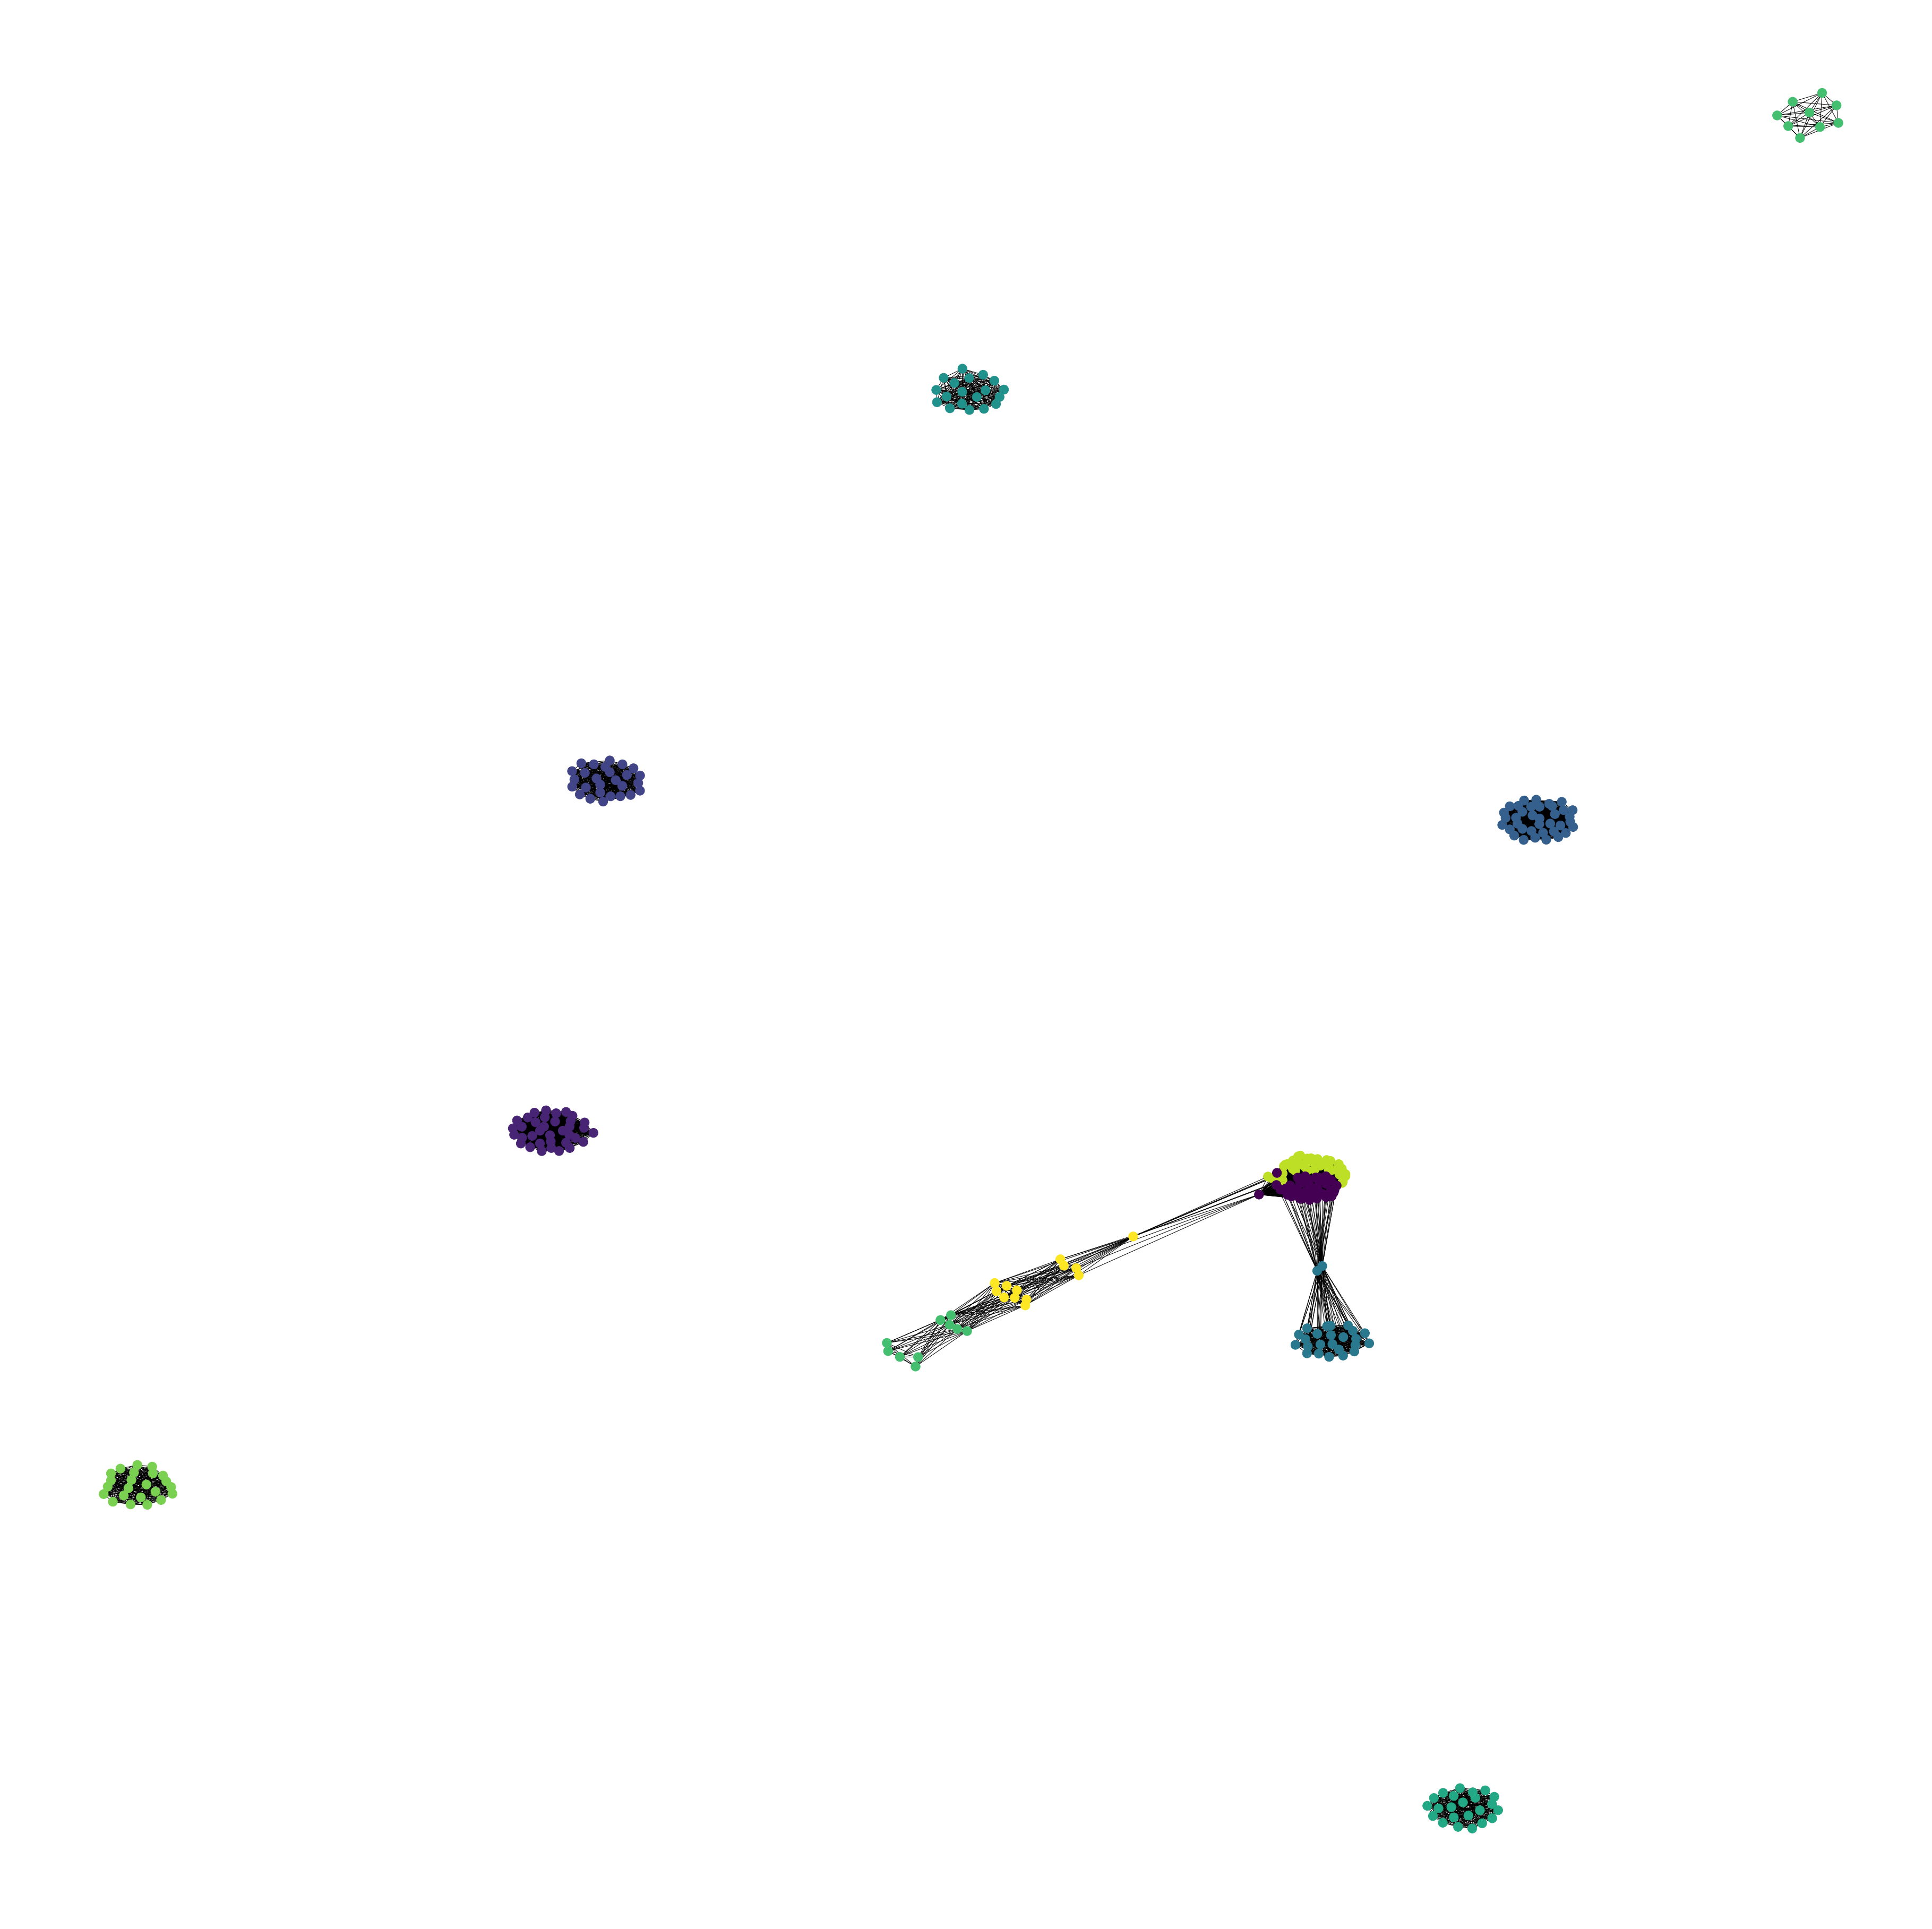

In [84]:
plt.figure(figsize=(50,50))
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def dfun(u, v):
    distance = sum(u==v)
    return distance
    if distance >2:
        return 1
    else:
        return 0


dm = pdist(fake.drop('label',axis=1), dfun)
net=squareform(dm)

import networkx as nx   
from networkx.drawing.nx_agraph import graphviz_layout
# Create a graph
G = nx.Graph()

# distances
#D = [ [0, 3,3], [3, 0,3],[3,3,0] ]
D = net

labels = {}

for n in range(len(D)):
    G.add_node(n)
    for m in range(len(D)-(n+1)):
        if D[n][n+m+1]>3:
            G.add_edge(n,n+m+1, length=10)
            #labels[ (n,n+m+1) ] = str(D[n][n+m+1])
pos=nx.spring_layout(G,scale=3)
#pos=nx.spring_layout(G)
color_map=fake.label
nx.draw(G,pos,node_color = color_map)
#nx.draw_networkx_edge_labels(G,pos,font_size=20)
#nx.draw(G, pos=graphviz_layout(G)) 

In [106]:
#Read CSV
#test using 20_24
test = '2017_12_13_20_24.csv'
test= pd.read_csv(test)
test=test.drop(['device_type','product_name','event_id','device_id','device_hw_form'],axis=1)
## drop row whose info is almost lost
test=test[test['device_hw_ram'].notnull()]
test.head()

,device_hw_proc,device_hw_ram,device_hw_display,device_hw_video,device_os_name,device_os_version
0,Intel(R) Core(TM) i7-4770S CPU @ 3.10GHz,8GB,1920x1080,Intel(R) HD Graphics 4600,Microsoft Windows 10 Home Single Language,10.0.16299 Build 16299
1,Intel(R) Core(TM) i7-3840QM CPU @ 2.80GHz,16GB,1920x1080,NVIDIA Quadro K3000M,Microsoft Windows 7 Enterprise,6.1.7601 Service Pack 1 Build 7601
2,Intel64 Family 6 Model 58 Stepping 9 Intel(R) Core(TM) i5-3470T CPU @ 2.90GHz,4GB 1910837248,"1920x1080 96,96 32","Intel(R) HD Graphics, PCI\VEN_8086&DEV_0152&SUBSYS_307917AA&REV_09\3&11583659&2&10",Microsoft Windows 7 Enterprise,6.1.7601 Service Pack 1 Build 7601
3,Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz,16GB,1920x1080,Intel(R) HD Graphics 530,Microsoft Windows 10 Pro,10.0.14393 Build 14393
4,x64 Family 20 Model 2 Stepping 0 AMD E-450 APU with Radeon(tm) HD Graphics,2GB 402653184,"1366x768 96,96 32","AMD Radeon HD 6320 Graphics, PCI\VEN_1002&DEV_9806&SUBSYS_84E31043&REV_00\3&11583659&3&08",Microsoft Windows 7 Начальная,6.1.7601 Service Pack 1 Build 7601


In [107]:
ins,test = cleandata(test.sample(2000,random_state=25),filterCPU=10, filterGPU=2000000,filterRAM=2)
test=test.drop(['device_hw_proc','device_hw_video','device_hw_ram','device_os_name','device_os_version','device_hw_display'],axis=1)

In [108]:
test=test.dropna()
#test.sample(1000,random_state=25).sort_values('GC')
test

,brand,GC,RAM,OS2,Screen
12507,Core(TM) i3-6100,Intel(R) HD Graphics 530,4,Windows Pro 6.1,1920x1080
310688,Core(TM) i7-7700HQ,Intel(R) HD Graphics 630,16,Windows Home 10.0,1920x1080
144945,Core(TM) i7-6700K,NVIDIA GeForce GTX 1080,32,Windows Pro 10.0,1920x1080
234273,Core(TM) i5-6200U,Intel(R) HD Graphics 520,8,Windows Home 10.0,1366x768
124394,Core(TM) i5-6200U,Intel(R) HD Graphics 520,8,Windows Home 10.0,1920x1080
271815,Core(TM) i5-4590,Intel(R) HD Graphics 4600,4,Windows Pro 6.1,1366x768
58304,Core(TM) i5- M 480,Intel(R) HD Graphics,4,Windows Pro 10.0,1366x768
282156,Rare,AMD(ATI) Radeon HD 7480D,3,Windows Pro 6.1,1920x1080
274849,AMD E-450 Radeon HD,AMD(ATI) Radeon HD 6320,4,Windows Home 10.0,1366x768
272239,Core(TM) i7-7700,NVIDIA GeForce GT 730,16,Windows Pro 10.0,1920x1080


In [109]:
#sample=test.sample(1000,random_state=25)
sample=test
sample=sample[(sample.RAM!='Rare')&(sample.brand!='Rare')]

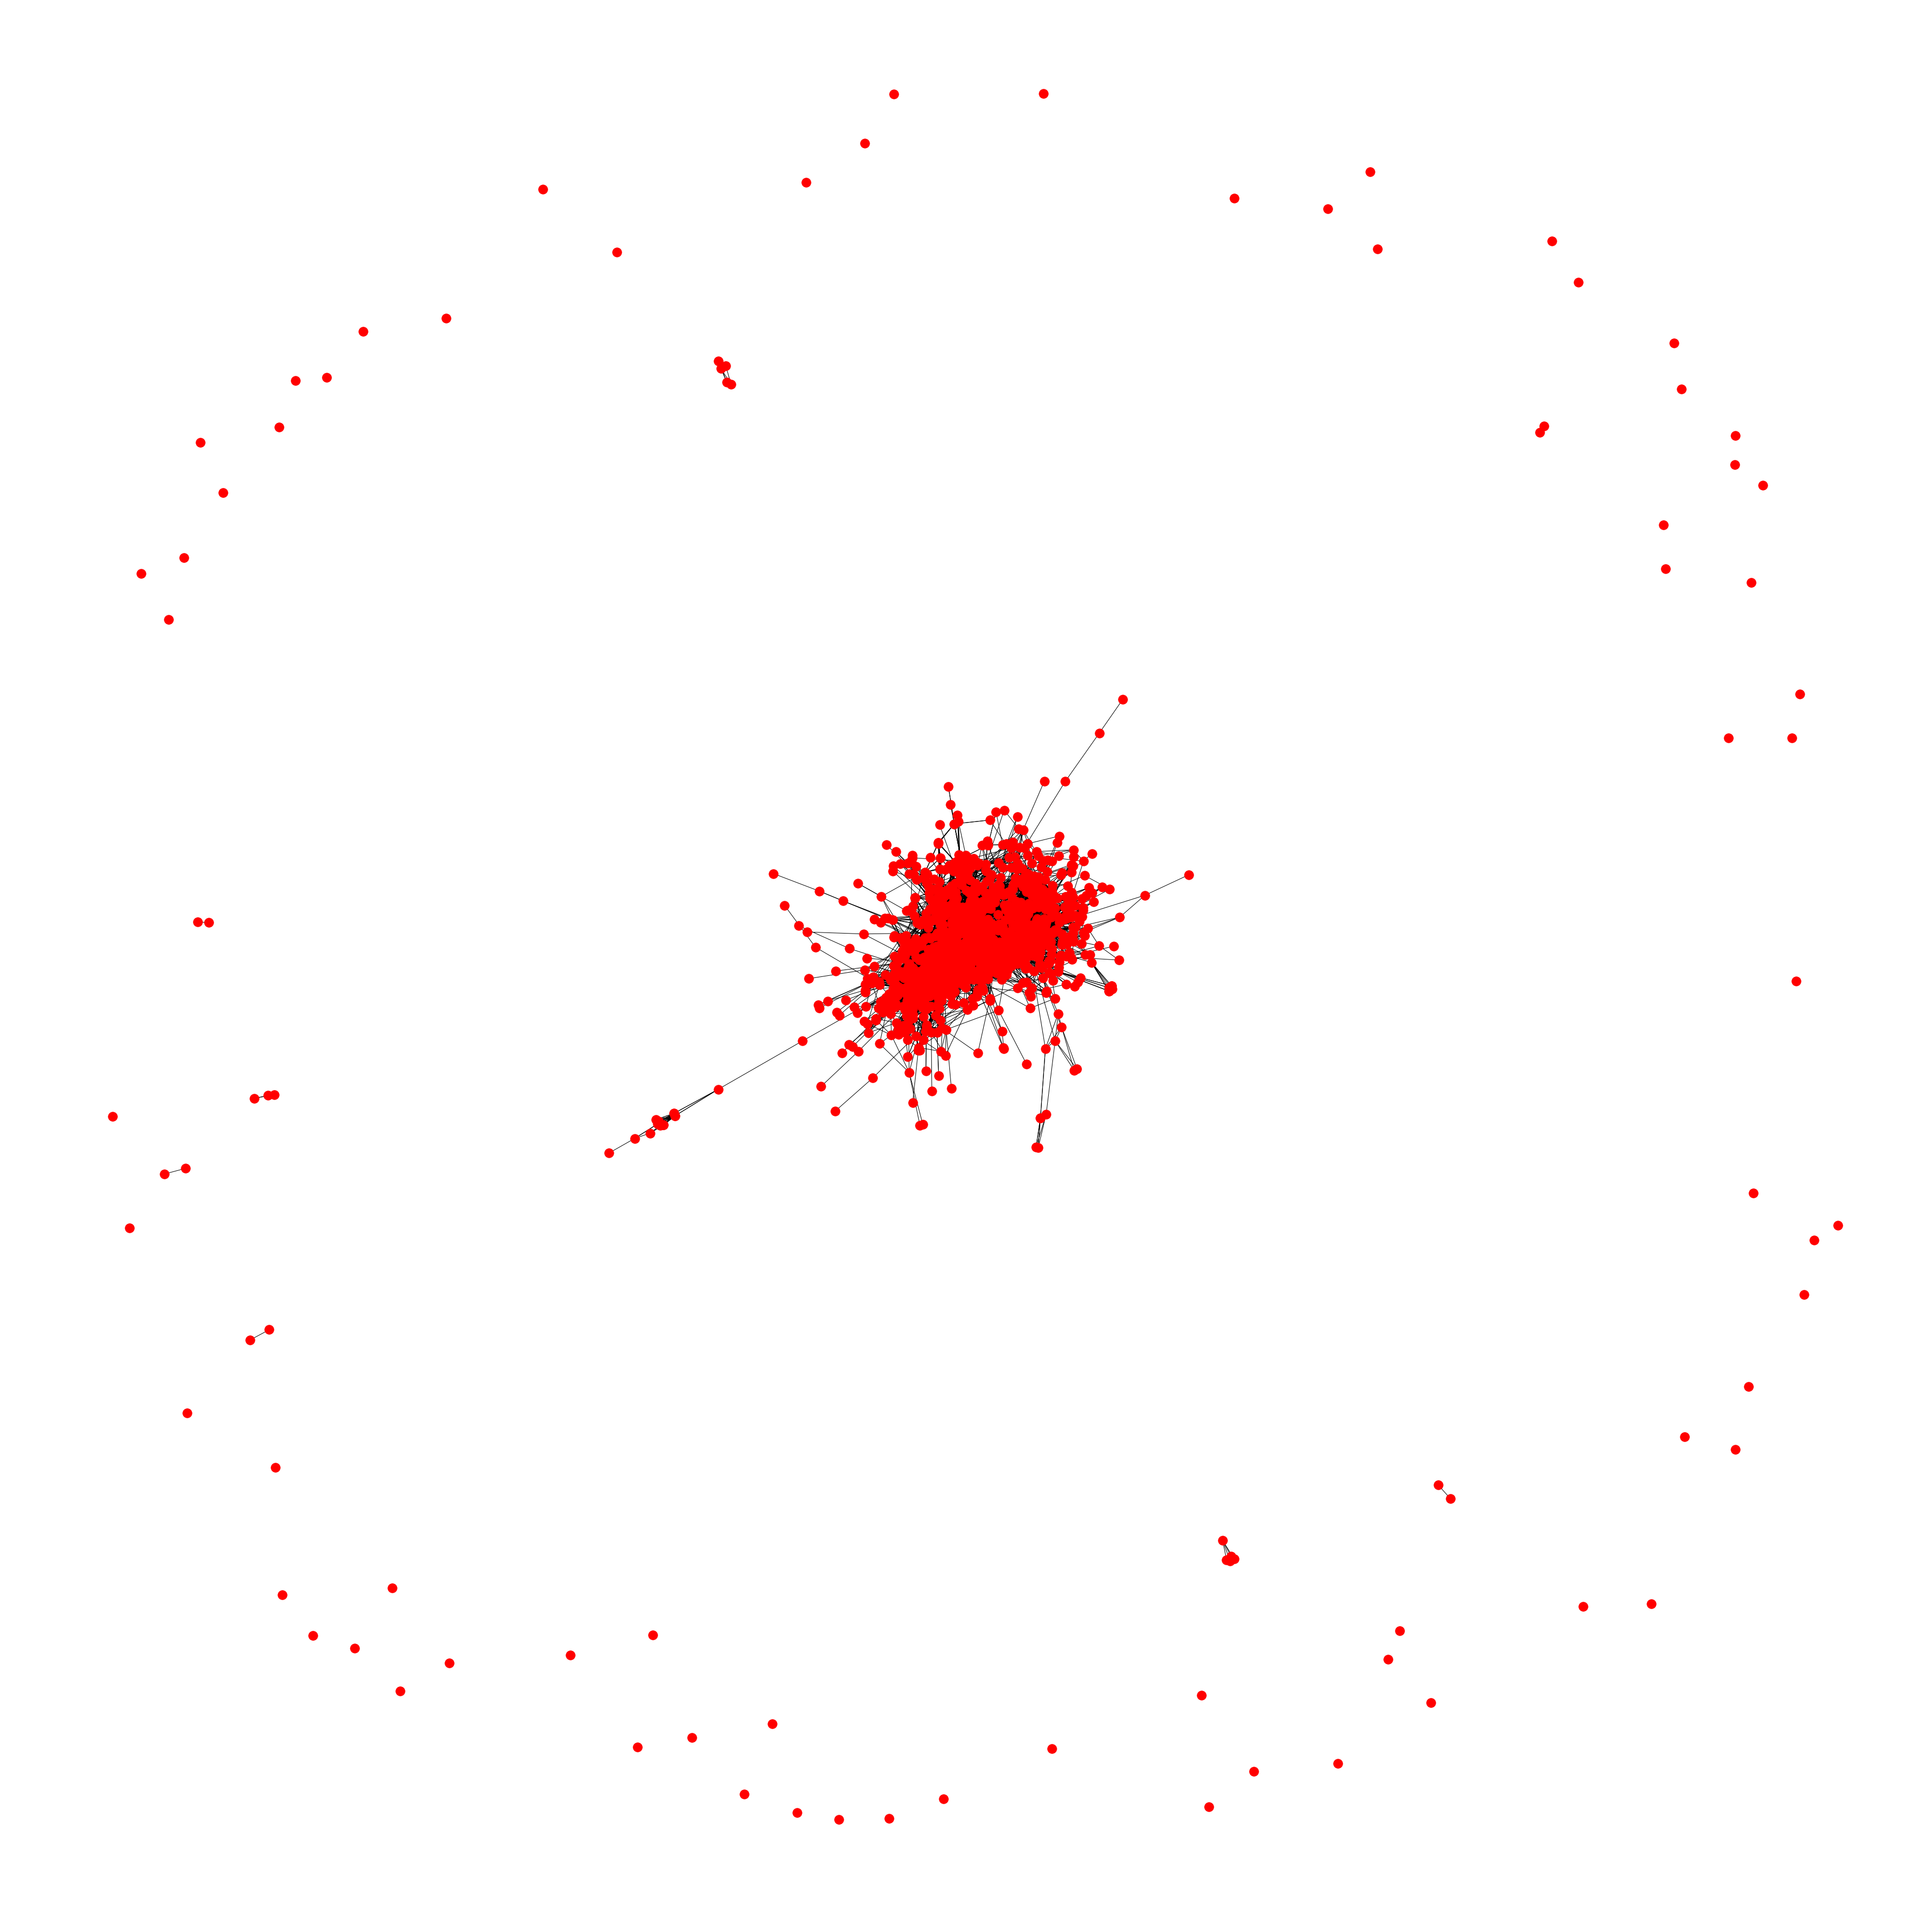

In [110]:
dm1 = pdist(sample, dfun)
net1=squareform(dm1)

plt.figure(figsize=(50,50))
import networkx as nx   

# Create a graph
G1 = nx.Graph()

# distances
#D = [ [0, 3,3], [3, 0,3],[3,3,0] ]
D1 = net1

labels = {}

for n in range(len(D1)):
    G1.add_node(n)
    for m in range(len(D1)-(n+1)):
        if D1[n][n+m+1]>2:
            G1.add_edge(n,n+m+1, length=20)
            #labels[ (n,n+m+1) ] = str(D[n][n+m+1])

#pos=nx.spring_layout(G)

nx.draw(G1)
#x.draw_spectral(G1) 
#x.draw_networkx_edge_labels(G,pos,font_size=20)
plt.savefig("graph.pdf")

In [60]:
(net1.sum(axis=1)<200).sum()

7

In [73]:
#plt.savefig("graph.png", dpi=1000)
plt.savefig("graph.pdf")

<Figure size 432x288 with 0 Axes>

In [76]:
import holoviews as hv

hv.extension('bokeh')
%%opts Graph [tools=['hover']]


SyntaxError: invalid syntax (<ipython-input-76-3015dad6314f>, line 4)

In [112]:
sample.sort_values('GC')

,brand,GC,RAM,OS2,Screen
264009,Xeon(R) E5-1620 v2,AMD(ATI) FirePro D500,16,Mac 10.11,2560x1440
86816,Core(TM) i5-3360M,AMD(ATI) FirePro M4000,16,Windows Pro 10.0,1920x1080
124366,Core(TM) i5-3340M,AMD(ATI) FirePro M4000 Mobility Pro,8,Windows Pro 6.3,1366x768
63185,Xeon(R) E5-1620 0,AMD(ATI) FirePro V (FireGL V) Adapter,24,Windows Entreprise 10.0,1920x1080
23781,Core(TM) i5-4570,AMD(ATI) FirePro V3900,16,Windows Pro 10.0,"(1366x768, 1366x768)"
36638,AMD FX(tm)-8120 Eight-Core Processor,AMD(ATI) FirePro V4800 (FireGL V),8,Windows Entreprise 6.3,1366x768
301161,Xeon(R) E31225,AMD(ATI) FirePro V4800 (FireGL) Adapter,8,Windows Pro 6.3,1680x1050
110444,Xeon(R) E5-1620 0,AMD(ATI) FirePro V4900,16,Windows Pro 6.1,1680x1050
303756,Core(TM) i7-4790K,AMD(ATI) FirePro V4900 (FireGL V),32,Windows Pro 10.0,"(1920x1200, 1920x1200)"
149934,Core(TM) i7-4770,AMD(ATI) FirePro V4900 (FireGL V),16,Windows Pro 10.0,"(1680x1050 Touch, 1680x1050)"
